In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.ion()
random = np.random.RandomState(seed=42)

# Simple Gaussian Process Regression

Gaussian Process regression code. Credits go for Nando de Freitas original implementation [here](http://www.cs.ubc.ca/~nando/540-2013/lectures/gp.py). The goal of this notebook is to be an interpretation of the code and update some of the parts for better understanding.

The code assumes a zero mean GP prior.

## Setup data

In [2]:
# this is the true function we are trying to approximate
f = lambda x: np.sin(0.9*x).flatten()

In [3]:
# setup
N = 10    # nº of training points
n = 50    # nº of test points
s = 1e-1  # noise variance

In [4]:
# sample some input points and noisy versions of the function evaluated at these points
X = random.uniform(-5, 5, size=(N, 1))
y = f(X) + s * random.randn(N)

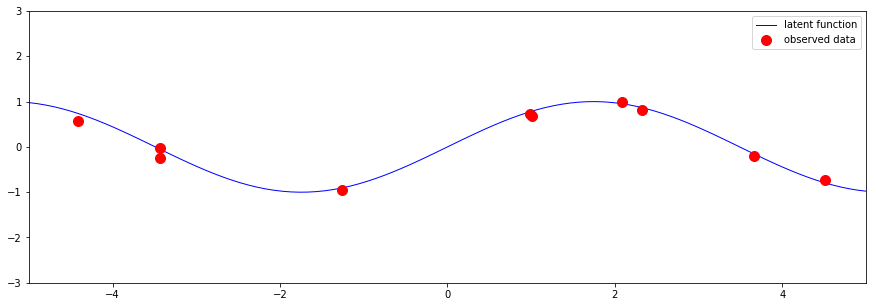

In [5]:
fig, ax = plt.subplots(figsize=(15, 5))

t = np.linspace(-5, 5, 100)
ax.axis([-5, 5, -3, 3])
ax.plot(t, f(t), 'b-', lw=1, label='latent function')
ax.plot(X, y, 'ro', ms=10, label='observed data')
ax.legend()

## Gaussian Process

Define a Kernel function (i.e. the way we want data to interact)

In [6]:
def kernel(a, b):
    """Squared exponential kernel. """
    kernelParameter = 0.1
    sqdist = np.sum(a**2, 1).reshape(-1, 1) + np.sum(b**2, 1) - 2*np.dot(a, b.T)
    return np.exp(-0.5 * (1/kernelParameter) * sqdist)

Now we obtain the kernel (covariance) for the data, i.e., $k(X, X)$

In [7]:
K = kernel(X, X)

We need the equivalent of $\sqrt{\text{K}}$ for matrices. For that we have the Cholesky Decomposition.

Notice that with noisy observations, $\text{K}$ takes the form

$\text{K}_y = \text{K} + \sigma_y^2 \mathbf{I}_N$

In [8]:
L = np.linalg.cholesky(K + s*np.eye(N))

Let's define the points we want to make predictions

In [9]:
Xtest = np.linspace(-5, 5, n).reshape(-1, 1)

Finally, we define the process as:

$
\begin{pmatrix} 
    \text{y} \\ 
    \text{f}_* 
\end{pmatrix} 
\sim \left(0, 
\begin{pmatrix}
    \text{K}_y & \text{K}_* \\ 
    \text{K}_*^T & \text{K}_{**}
\end{pmatrix} 
\right )
$

where

$\mu_* = \text{K}_*^T \text{K}_y^{-1}\text{y}$

$\sigma_*^2 = \text{K}_{**} - \text{K}_*^T \text{K}_y^{-1} \text{K}_*$

In [10]:
# mean
Lk = np.linalg.solve(L, kernel(X, Xtest))
mu = np.dot(Lk.T, np.linalg.solve(L, y))

# variance
K_ = kernel(Xtest, Xtest)
s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
s  = np.sqrt(s2)

### Mean explanation

To calculate the mean using the above formula, we must use an alternative method, since $\text{K}_y$ is not easily invertible (unstable). 

Instead, we use the Cholesky decomposition $\text{K}_y = \text{L}\text{L}^T$ and define the following relation

$\text{K}_y^{-1}\text{y} = \text{L}^{-T}\text{L}^{-1}\text{y}$ 

This is much easier to compute, because if

$m = \text{L}^{-1}\text{y}$

$\Rightarrow \text{L}m = \text{y}$

In order to compute $m$ we solve a linear system of equations, with matrix $\text{L}$ and vector $\text{y}$. This avoids the explicit calculation of an inverse.

We now have the following equation for the mean

$\mu_{*} = \text{K}_{*}^{T} \text{L}^{-T} m$

Since we have $m$ already, we only need $\text{K}_{*}^{T} L^{-T}$. We can do a similar trick as before, but taking into account that these are transposes. Let's define the following relation

$v = \text{L}^{-1}\text{K}_{*}$

$\Rightarrow \text{L}v = \text{K}_{*}$

once we solve for $v$, we can take its transpose and get

$v^{T} = (\text{L}^{-1}\text{K}_{*})^T = \text{K}_{*}^{T} L^{-T}$

Finally, we just take the dot product between $v^T$ and $m$ to get the mean

$\mu_{*} = \left< v^T, m \right>$

**Note:** in the code, $v$ corresponds to the variable `Lk`

### Variance explanation

We can use the same replacement as before, where $K_y = \text{L}\text{L}^T$

$\sigma_*^2 = \text{K}_{**} - \text{K}_*^T \text{L}^{-T} \text{L}^{-1} \text{K}_*$

here, we can use the relation $v = \text{L}^{-1}\text{K}_{*}$, which was already calculated for the mean computation

$\sigma_*^2 = \text{K}_{**} - v^{T}v$

finally, $\text{K}_{**}$ is just the diagonal of the kernel $k(X_*, X_*)$

$\sigma_*^2 = diag(k(X_*, X_*)) - v^{T}v$

If you need to get the standard deviation for plotting, we take the square root of this value.

## Visualize

### Mean with Standard Deviation

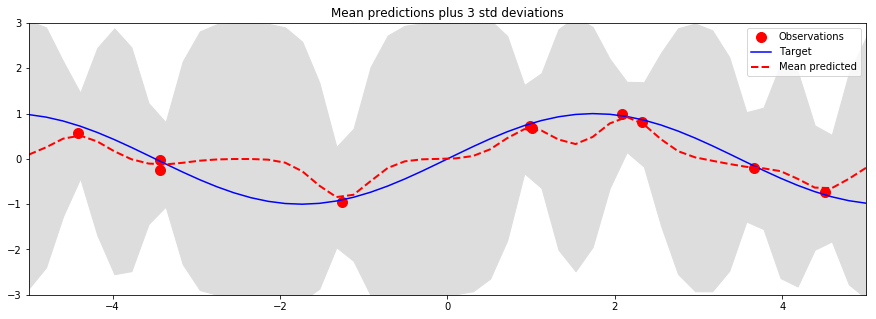

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(X, y, 'ro', ms=10, label='Observations')
ax.plot(Xtest, f(Xtest), 'b-', label='Target')
fig.gca().fill_between(Xtest.flat, mu - 3 * s, mu + 3 * s, color="#dddddd")
ax.plot(Xtest, mu, 'r--', lw=2, label='Mean predicted')
ax.axis([-5, 5, -3, 3])
ax.set_title('Mean predictions plus 3 std deviations')
ax.legend()

### Sampling from the distributions

Text(0.5,1,'Ten samples from the GP prior')

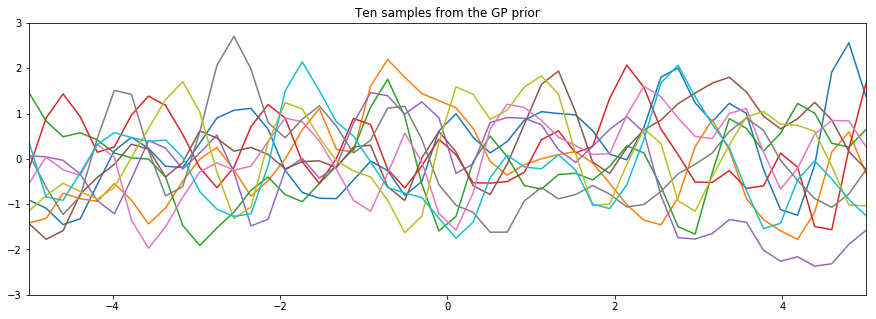

In [12]:
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n))
f_prior = np.dot(L, random.normal(size=(n, 10)))

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(Xtest, f_prior)
ax.axis([-5, 5, -3, 3])
ax.set_title('Ten samples from the GP prior')

Since the prior is just a Gaussian with mean 0 and std 1, there is no relation to observations.

### Draw samples from the posterior at our test points

Text(0.5,1,'Ten samples from the GP posterior')

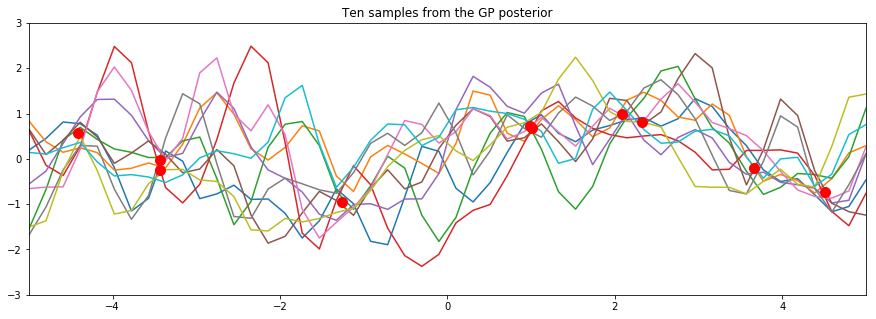

In [13]:
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1, 1) + np.dot(L, random.normal(size=(n, 10)))

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(Xtest, f_post)
ax.plot(X, y, 'ro', ms=10, label='Observations')
ax.axis([-5, 5, -3, 3])
ax.set_title('Ten samples from the GP posterior')

The distribution's variance gets lower at observed points this time!